# 1. Setup and Imports

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

# 2. Data Loading and Initial Exploration

In [ ]:

path = "/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images"
images = []
labels = []

# Iterate through each folder in the specified path
for folder in os.listdir(path):
    subfolder_path = os.path.join(path, folder)  # Correctly define subfolder_path
    if os.path.isdir(subfolder_path):  # Check if it's a directory
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(folder)

# Create a DataFrame from the lists
df = pd.DataFrame({'image': images, 'label': labels})
df


,image,label
0,/kaggle/input/alzheimers-multiclass-dataset-eq...,ModerateDemented
1,/kaggle/input/alzheimers-multiclass-dataset-eq...,ModerateDemented
2,/kaggle/input/alzheimers-multiclass-dataset-eq...,ModerateDemented
3,/kaggle/input/alzheimers-multiclass-dataset-eq...,ModerateDemented
4,/kaggle/input/alzheimers-multiclass-dataset-eq...,ModerateDemented
...,...,...
43995,/kaggle/input/alzheimers-multiclass-dataset-eq...,MildDemented
43996,/kaggle/input/alzheimers-multiclass-dataset-eq...,MildDemented
43997,/kaggle/input/alzheimers-multiclass-dataset-eq...,MildDemented
43998,/kaggle/input/alzheimers-multiclass-dataset-eq...,MildDemented


# 3. Class Distribution

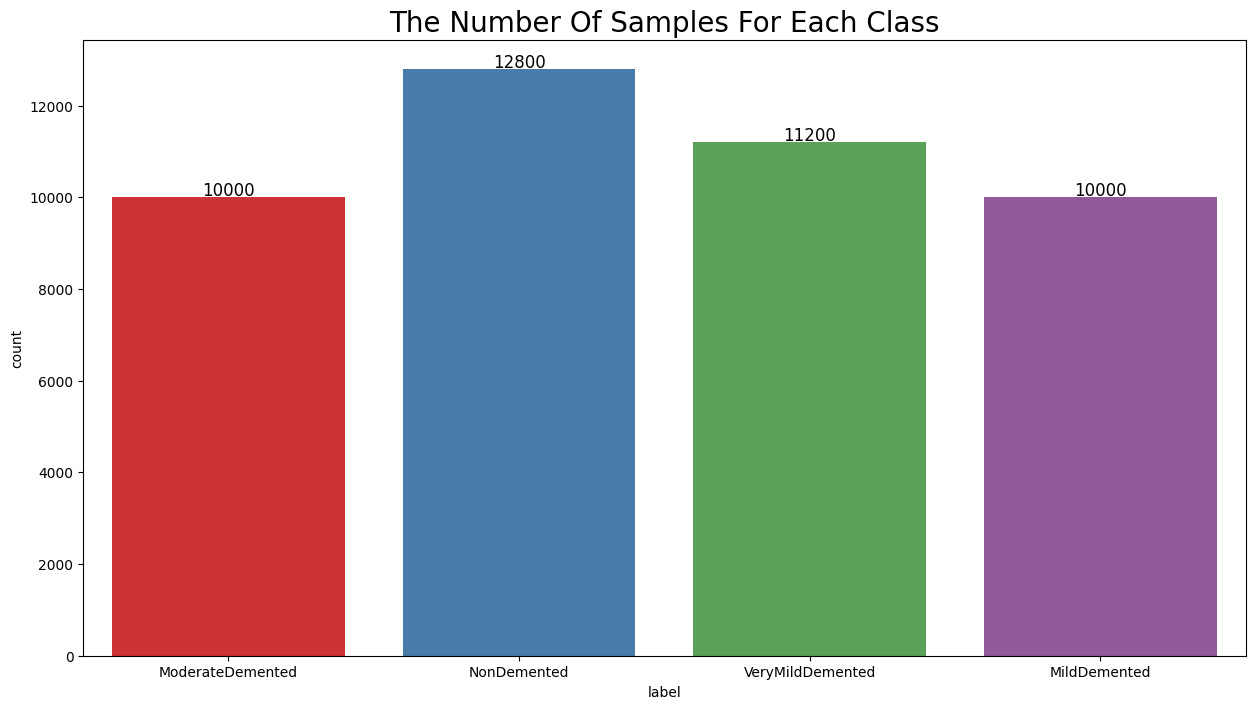

In [ ]:
# Assuming `df` is  DataFrame and `label` is the column with class labels
class_counts = df['label'].value_counts()


# Plot the class distribution
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=df['label'], palette='Set1')
plt.title('The Number Of Samples For Each Class', fontsize=20)
plt.grid(False)


# Annotate each bar with the exact count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

# 4. Data Preprocessing and Augmentation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # Import VGG16

# Assuming df is your original DataFrame containing all data

# Step 1: Split the DataFrame into training and test sets (e.g., 80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)  # 80% train, 20% test

# Step 2: Create the training data generator with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,  # Use VGG preprocessing
    horizontal_flip=True,

)

# Create the training data generator from the training DataFrame
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=0
)

# Step 3: Create a validation data generator from the test set using ImageDataGenerator
validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,  # Use VGG preprocessing
    validation_split=0.5  # Use 50% of the test set for validation
)

# Create the validation data generator from the test DataFrame
valid_generator = validation_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation',  # Specify that this is the validation subset
    seed=0
)

# Optional: Create a test data generator (if you want to keep the test set separate)
test_generator = validation_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',  # Optional; you might not need labels for inference
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' if you have labels; otherwise, use None
    shuffle=False,
    subset='training',  # Specify that this is the test subset
    seed=0
)


Found 35200 validated image filenames belonging to 4 classes.
Found 4400 validated image filenames belonging to 4 classes.
Found 4400 validated image filenames belonging to 4 classes.


# 5. Visualize Sample Images

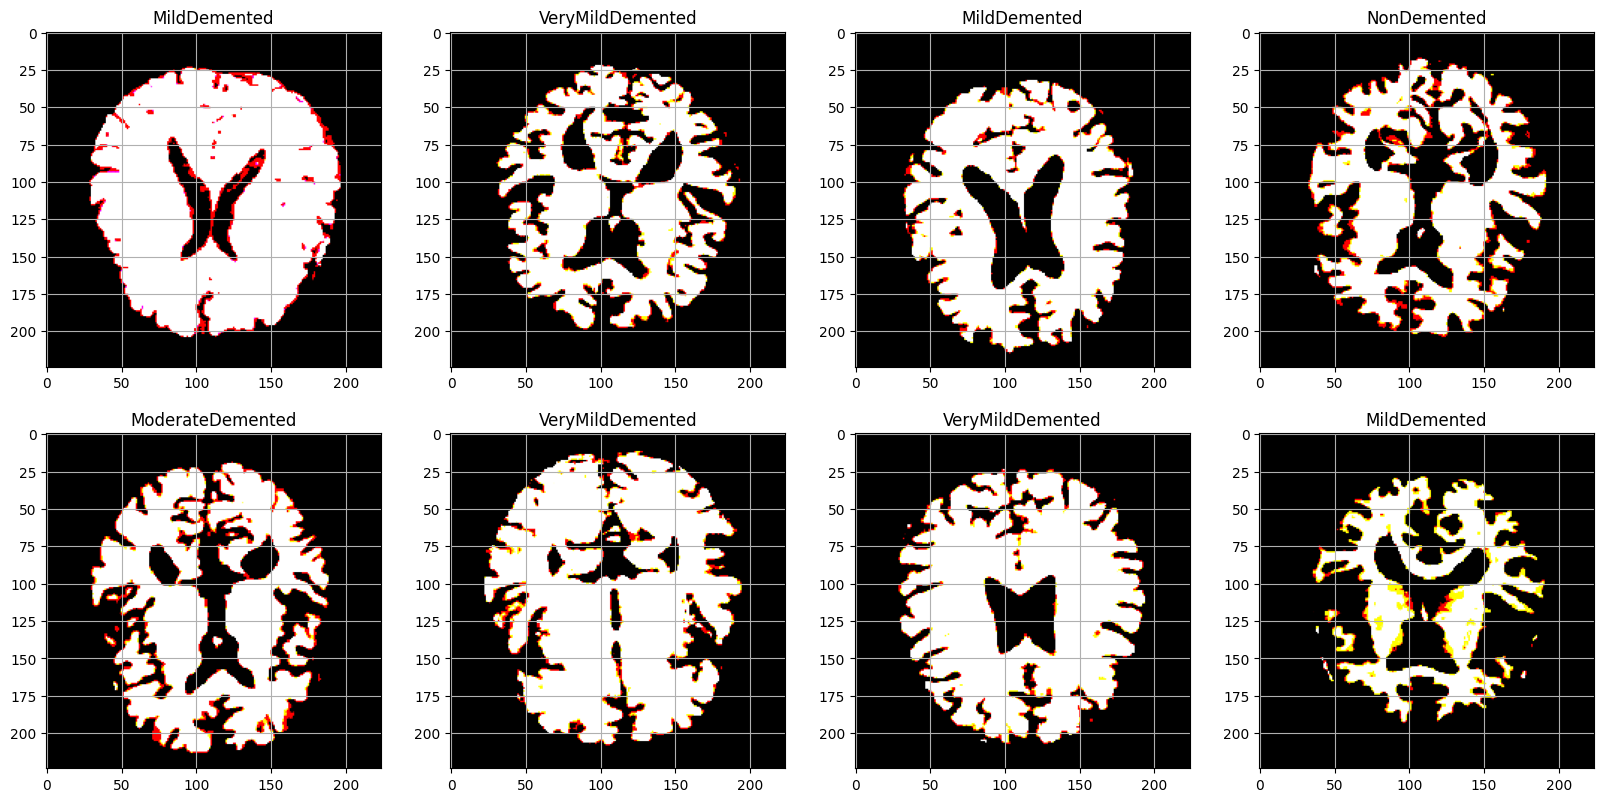

In [ ]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,8):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        # plt.title(classes[int(y_batch[i])])   # when y is binary or sparse
        plt.grid(None)
    # show the plot
    plt.show()
    break

# 6. Model Architecture

In [ ]:

model = keras.models.Sequential()
model.add(tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet'))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())#normaize and optimization for input data
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))
model.layers[0].trainable = False

# Build the model with the correct input shape
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,881,924 (68.21 MB)

 Trainable params: 3,160,068 (12.05 MB)

 Non-trainable params: 14,721,856 (56.16 MB)

# 7. Model Compilation and Callbacks

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
# The model will be automatically saved to 'best_model.keras' when 'val_loss' improves.

model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001)

callbacks=[early_stopping,model_checkpoint,model_ReduceLROnPlateau]

In [ ]:


# Load the best weights
model.load_weights('best_model.weights.h5')


# 9. Model Training

In [ ]:
# Training the model
history = model.fit(train_generator,
                    epochs          = 30,
                    batch_size=32,
                    validation_data = valid_generator,
                    callbacks = callbacks
                    )

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1741652909.050295     119 service.cc:145] XLA service 0x7ccb0c0063d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741652909.050362     119 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   2/1100 ━━━━━━━━━━━━━━━━━━━━ 1:19 73ms/step - accuracy: 1.0000 - loss: 0.0214 - precision: 1.0000 - recall: 1.0000  

I0000 00:00:1741652918.910950     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 653s 578ms/step - accuracy: 0.9797 - loss: 0.0550 - precision: 0.9809 - recall: 0.9789 - val_accuracy: 0.9732 - val_loss: 0.0755 - val_precision: 0.9738 - val_recall: 0.9720 - learning_rate: 1.0000e-04
Epoch 2/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 388s 350ms/step - accuracy: 0.9836 - loss: 0.0480 - precision: 0.9843 - recall: 0.9827 - val_accuracy: 0.9814 - val_loss: 0.0524 - val_precision: 0.9825 - val_recall: 0.9805 - learning_rate: 1.0000e-04
Epoch 3/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 390s 353ms/step - accuracy: 0.9830 - loss: 0.0472 - precision: 0.9838 - recall: 0.9822 - val_accuracy: 0.9820 - val_loss: 0.0562 - val_precision: 0.9827 - val_recall: 0.9816 - learning_rate: 1.0000e-04
Epoch 4/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 396s 357ms/step - accuracy: 0.9834 - loss: 0.0483 - precision: 0.9844 - recall: 0.9826 - val_accuracy: 0.9798 - val_loss: 0.0586 - val_precision: 0.9804 - val_recall: 0.9795 - learning_rate: 1.0000e-04
Epoch 5/30
1100/1100 ━━━━━━━━━━━━━━

# 10. Training History

In [ ]:
hist_=pd.DataFrame(history.history)
hist_

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall,learning_rate
0,0.980824,0.053676,0.982283,0.979688,0.973182,0.075485,0.973816,0.972045,0.0001
1,0.982727,0.049421,0.983522,0.981761,0.981364,0.052365,0.982464,0.980455,0.0001
2,0.983097,0.046890,0.983837,0.982244,0.982045,0.056226,0.982708,0.981591,0.0001
3,0.982528,0.049258,0.983439,0.981818,0.979773,0.058619,0.980437,0.979545,0.0001
4,0.983040,0.046306,0.984119,0.982358,0.981591,0.056534,0.982249,0.980909,0.0001
5,0.983523,0.045776,0.984547,0.982841,0.979545,0.055938,0.980209,0.979318,0.0001
6,0.985966,0.041054,0.986715,0.985369,0.981364,0.061210,0.983144,0.980909,0.0001


# 11. Model Evaluation

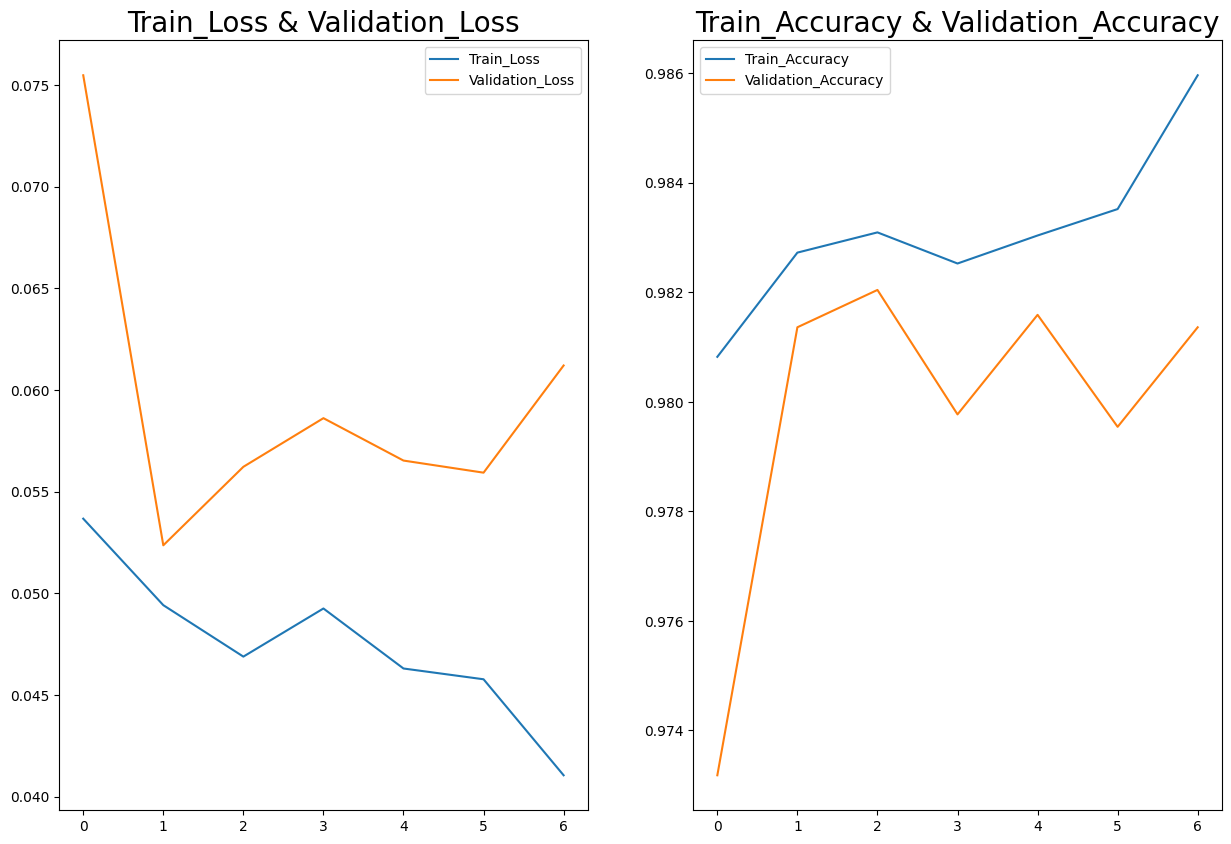

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
loss, accuracy, precision, recall = model.evaluate(valid_generator)
f1_score = 2 * (precision * recall) / (precision + recall)
# Create a dictionary with the metric names and values
metrics_dict = {
    'Metric': ['Val Loss', 'Val Accuracy', 'Val Precision', 'Val Recall' ,'f1_score'],
    'Value': [loss, accuracy, precision, recall,f1_score]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

metrics_df

,Metric,Value
0,Val Loss,0.052365
1,Val Accuracy,0.981364
2,Val Precision,0.982464
3,Val Recall,0.980455
4,f1_score,0.981458


In [ ]:

# Assuming you have the values for loss, accuracy, precision, and recall
loss, accuracy, precision, recall = model.evaluate(test_generator)

# Create a dictionary with the metric names and values
metrics_dict = {
    'Metric': ['test Loss', 'test Accuracy', 'test Precision', 'test Recall'],
    'Value': [loss, accuracy, precision, recall]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Display the DataFrame
metrics_df


138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9759 - loss: 0.0640 - precision: 0.9765 - recall: 0.9733


,Metric,Value
0,test0 Loss,0.061009
1,test Accuracy,0.977727
2,test Precision,0.978583
3,test Recall,0.976136


# 12. Analyze Predictions

In [ ]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step


,Actual,Prediction
0,2,2
1,0,0
2,0,0
3,1,1
4,0,0
...,...,...
4395,1,1
4396,0,0
4397,1,1
4398,0,0


In [ ]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num ,output_dict=True)
ClassificationReport = pd.DataFrame(ClassificationReport).transpose()
ClassificationReport

,precision,recall,f1-score,support
MildDemented,0.988347,0.972888,0.980557,959.000000
ModerateDemented,0.999001,1.000000,0.999500,1000.000000
NonDemented,0.967007,0.974663,0.970820,1263.000000
VeryMildDemented,0.962775,0.966044,0.964407,1178.000000
accuracy,0.977727,0.977727,0.977727,0.977727
macro avg,0.979283,0.978399,0.978821,4400.000000
weighted avg,0.977797,0.977727,0.977744,4400.000000


array([[ 933,    0,   12,   14],
       [   0, 1000,    0,    0],
       [   2,    0, 1231,   30],
       [   9,    1,   30, 1138]])

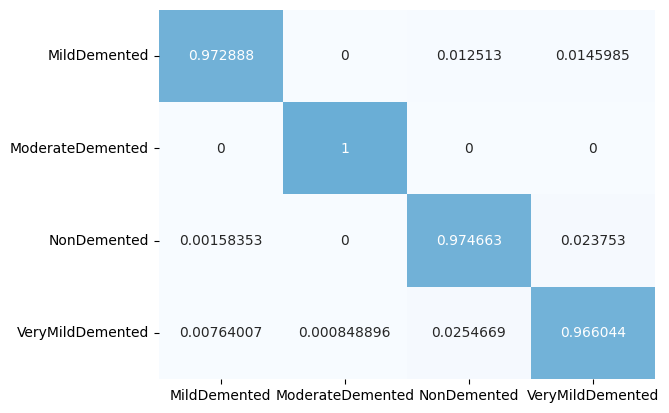

In [ ]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

#Visualize Results.

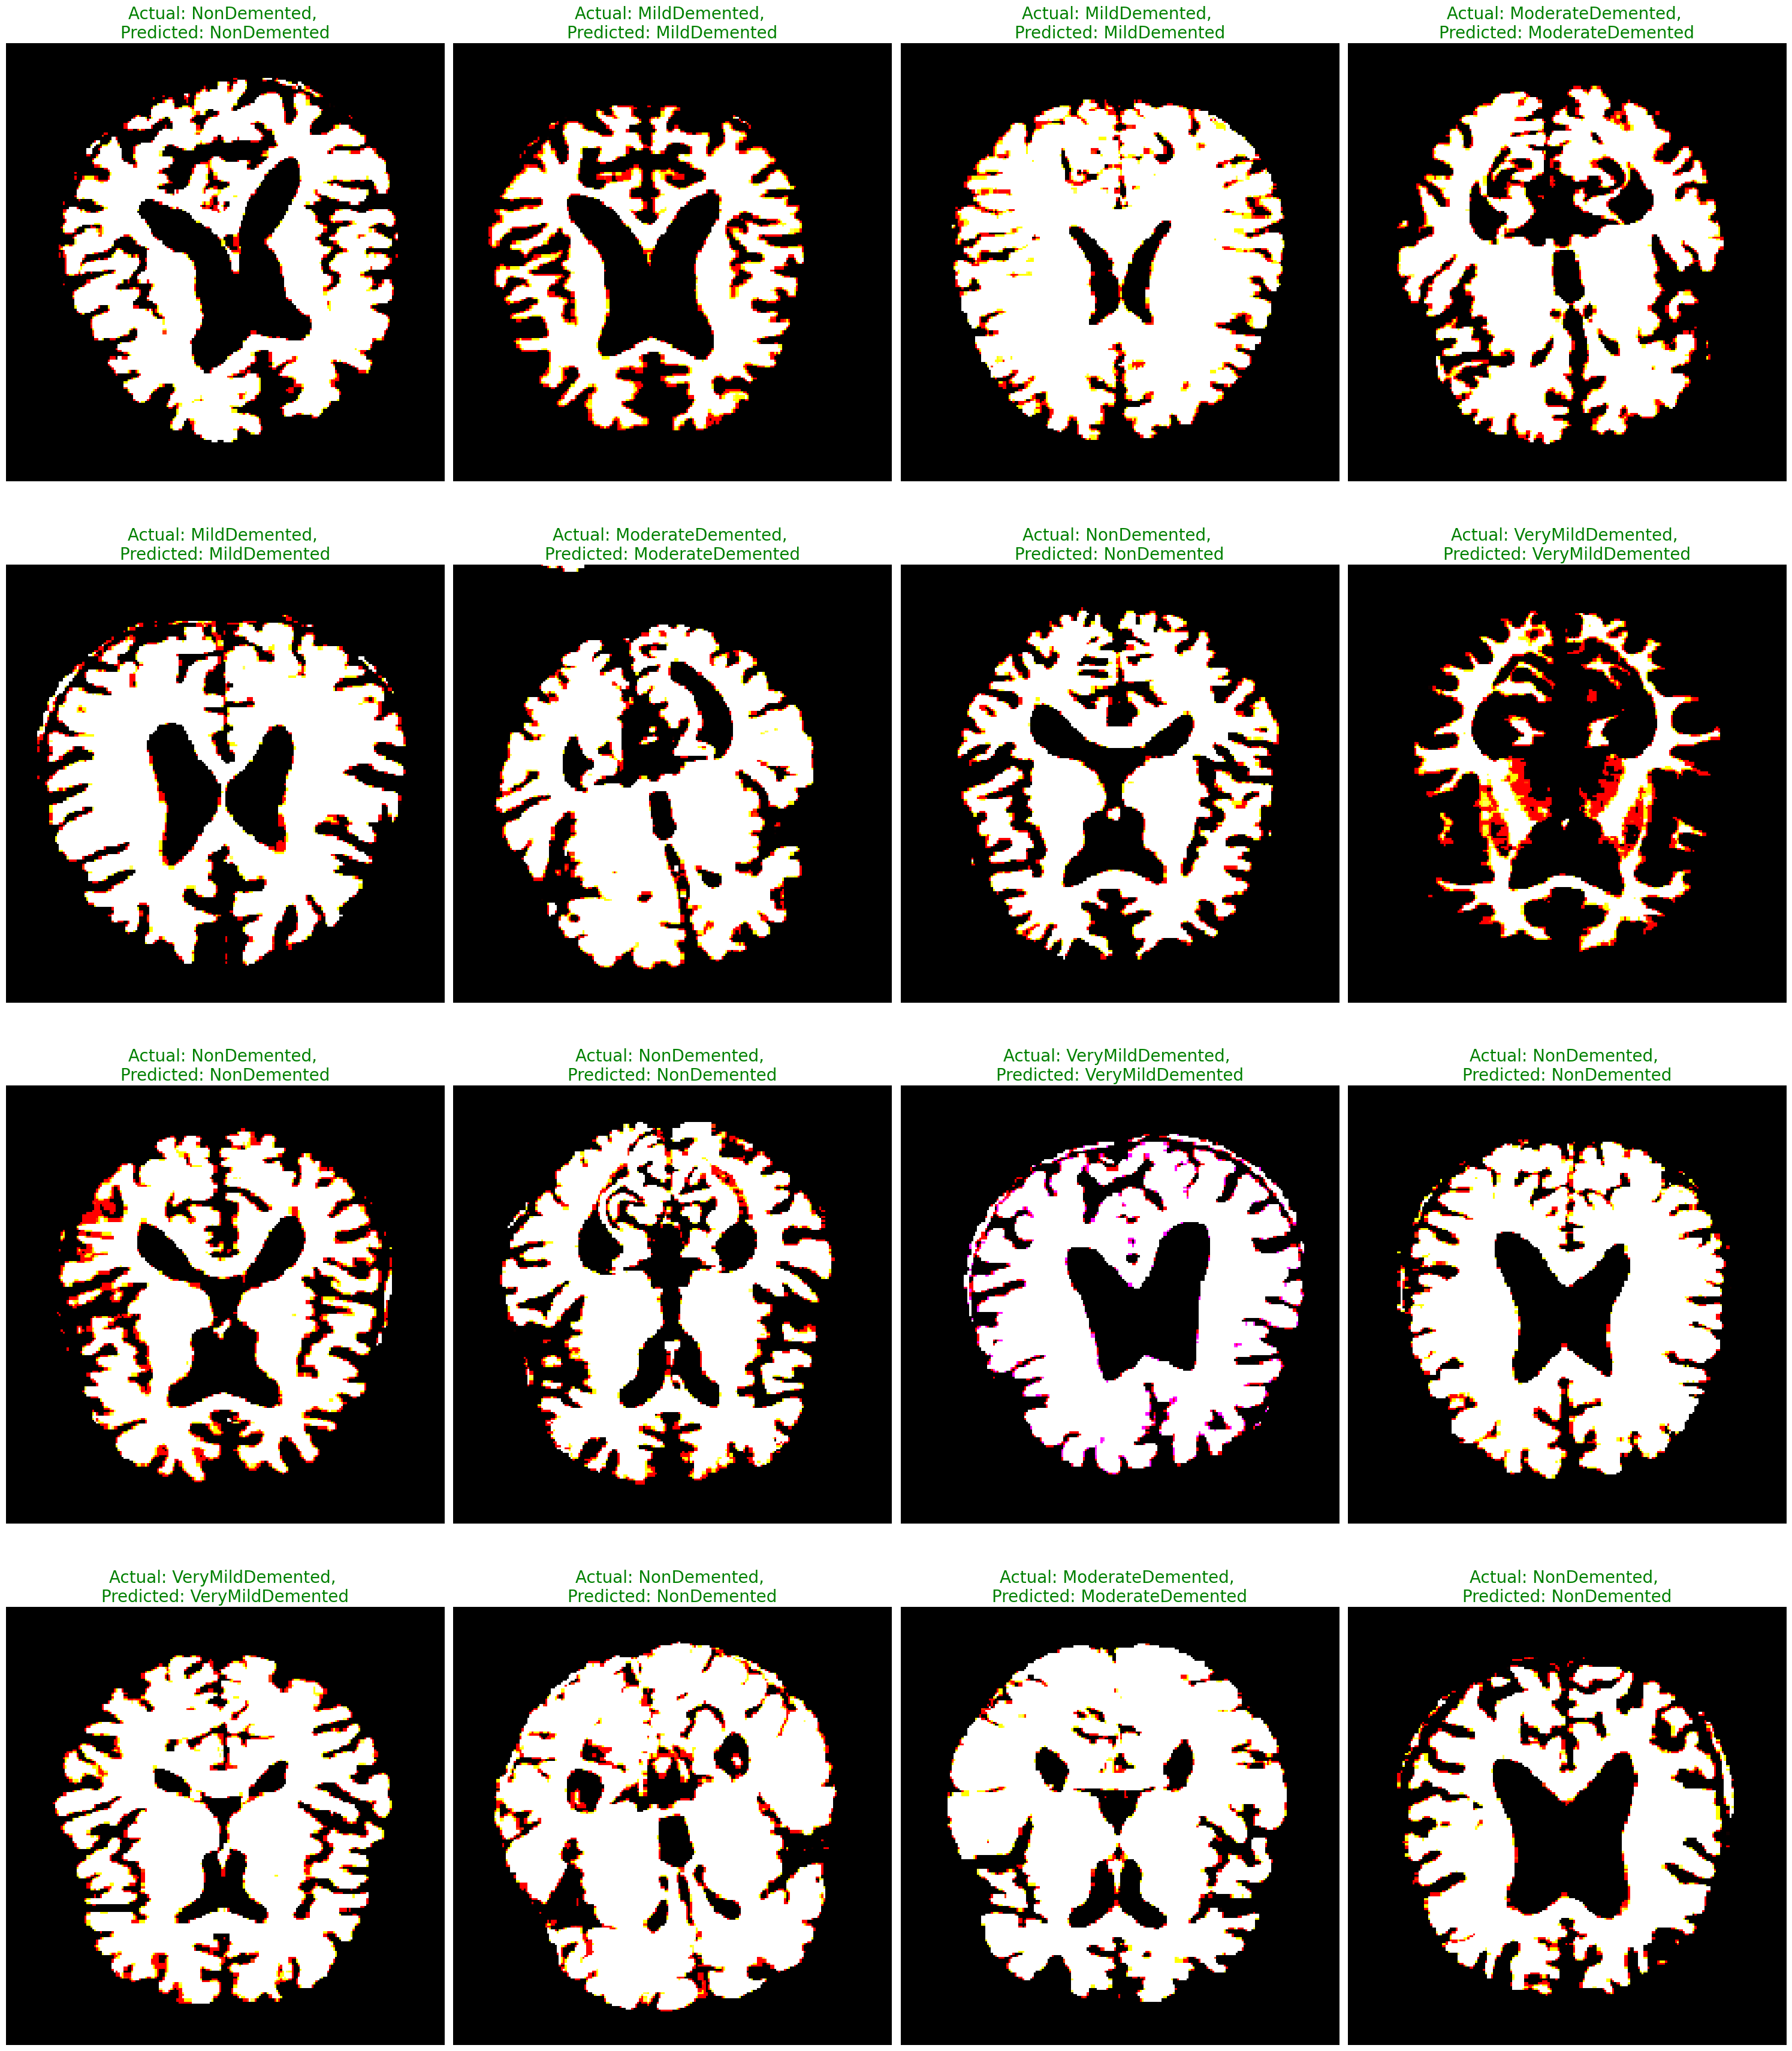

In [ ]:

# Assuming you have y_test and y_pred defined
class_num = list(train_generator.class_indices.keys())
plt.figure(figsize=(30, 70))
batch = next(test_generator)
images = batch[0]

for n in range(16):
    plt.subplot(8, 4, n + 1)
    plt.imshow(images[n])
    plt.axis('off')

    # Determine the title color based on prediction correctness
    if y_test[n] == y_pred[n]:
        color = 'green'
    else:
        color = 'red'

    # Set the title with the appropriate color
    plt.title(f"Actual: {class_num[y_test[n]]}, \nPredicted: {class_num[y_pred[n]]}", fontsize=20, color=color)

plt.tight_layout()
plt.show()


# 13. Save Trained Model

In [ ]:
model.save('best_model.keras')